<a href="https://colab.research.google.com/github/harshil017/TImeSeries/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-alpha0


In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


In [4]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

Text(0, 0.5, 'Close Price (USD)')

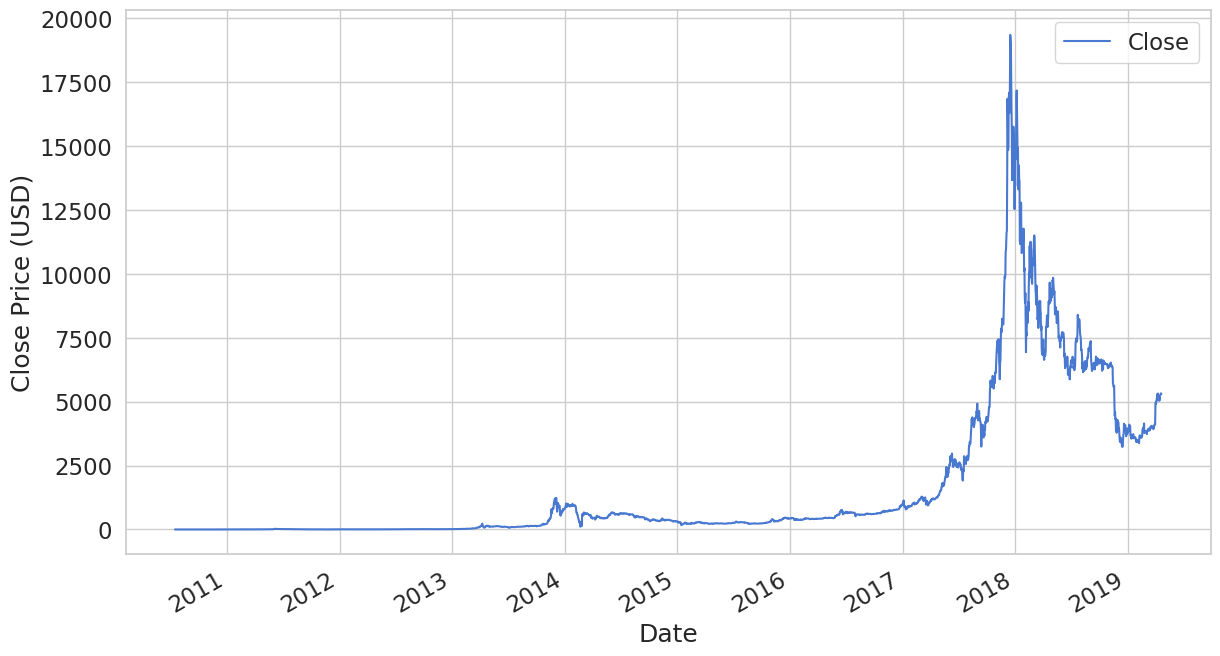

In [6]:
df = pd.read_csv(csv_path, parse_dates=['Date'])
df = df.sort_values('Date')
df.head()
df.shape
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [13]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

scaled_close.shape

np.isnan(scaled_close).any()

scaled_close = scaled_close[~np.isnan(scaled_close)]

scaled_close = scaled_close.reshape(-1, 1)

np.isnan(scaled_close).any()

False

In [20]:
# Define the parameter grid for hyperparameter tuning
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)
# Define the ARIMA order for hyperparameter tuning (you can modify this grid as needed)
param_grid = {
    'p': range(3),  # AR order (try values from 0 to 2)
    'd': range(2),  # Differencing order (try values 0 and 1)
    'q': range(3)   # MA order (try values from 0 to 2)
}

# Convert y_train and y_test to pandas Series with date index
y_train_series = pd.Series(y_train.flatten(), index=X_train.index)
y_test_series = pd.Series(y_test.flatten(), index=X_test.index)

# Hyperparameter tuning using GridSearch
best_mse = float('inf')
best_params = None

for p in param_grid['p']:
    for d in param_grid['d']:
        for q in param_grid['q']:
            try:
                arima_model = ARIMA(y_train_series, order=(p, d, q))
                arima_model_fit = arima_model.fit()

                # Get the forecasted values on the test set
                forecast, stderr, conf_int = arima_model_fit.forecast(len(y_test_series))

                # Calculate Mean Squared Error (MSE) to evaluate the model performance
                mse = mean_squared_error(y_test_series, forecast)

                if mse < best_mse:
                    best_mse = mse
                    best_params = (p, d, q)

            except:
                continue

# Fit the ARIMA model with the best hyperparameters on the full training data
arima_model_optimal = ARIMA(pd.concat([y_train_series, y_test_series]), order=best_params)
arima_model_fit_optimal = arima_model_optimal.fit()

# Get the forecasted values on the test set using the optimal model
forecast_optimal, stderr_optimal, conf_int_optimal = arima_model_fit_optimal.forecast(len(y_test_series))

# Calculate Mean Squared Error (MSE) to evaluate the optimal model performance
mse_optimal = mean_squared_error(y_test_series, forecast_optimal)
print("Optimal ARIMA Order:", best_params)
print("Mean Squared Error (MSE) of Optimal Model:", mse_optimal)

# Plot the actual and forecasted values for the optimal model
plt.figure(figsize=(10, 6))
plt.plot(y_train_series.index, y_train_series, label='Train', color='blue')
plt.plot(y_test_series.index, y_test_series, label='Test', color='green')
plt.plot(y_test_series.index, forecast_optimal, label='Forecast', color='red')
plt.fill_between(y_test_series.index, conf_int_optimal[:, 0], conf_int_optimal[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Optimal ARIMA Model Forecast')
plt.legend()
plt.show()

AttributeError: ignored

In [ ]:
# ARIMA Model
def arima_model(train_data, test_data):
    model = ARIMA(train_data['Price'], order=(5,1,0))  # (p, d, q)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test_data))
    predictions = pd.DataFrame(predictions, columns=['Price'])
    predictions['Date'] = test_data['Date'].reset_index(drop=True)
    plot_predictions(test_data, predictions, 'ARIMA')
    return predictions


In [ ]:
def holt_winters_hyperparameter_tuning(data):
    best_mae = float('inf')
    best_params = None

    for seasonal in ['add', 'mul']:
        for seasonal_periods in [7, 14, 21]:
            try:
                model = ExponentialSmoothing(data, seasonal=seasonal, seasonal_periods=seasonal_periods)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=30)  # Forecasting 30 days ahead
                mae = mean_absolute_error(data[-30:], forecast)
                if mae < best_mae:
                    best_mae = mae
                    best_params = (seasonal, seasonal_periods)
            except:
                continue

    return best_params

In [ ]:
from keras.layers import LSTM, Dense

# ... (The previous code for data generation, train-test split, and plotting functions)

# LSTM Model
def lstm_model(train_data, test_data):
    # Prepare data for LSTM
    def create_lstm_dataset(data, look_back=1):
        dataX, dataY = [], []
        for i in range(len(data) - look_back):
            dataX.append(data[i:(i + look_back)])
            dataY.append(data[i + look_back])
        return np.array(dataX), np.array(dataY)

    # Normalize the data (LSTMs are sensitive to the scale of the input)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(train_data['Price'].values.reshape(-1, 1))

    # Set the look-back window for LSTM (number of previous time steps to consider)
    look_back = 30

    # Create LSTM dataset
    trainX, trainY = create_lstm_dataset(scaled_data, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

    # Prepare test data for prediction
    last_window = scaled_data[-look_back:]
    testX = np.array([last_window])
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    # Make predictions with LSTM
    predictions = []
    for i in range(len(test_data)):
        prediction = model.predict(testX)
        predictions.append(prediction[0][0])
        testX = np.roll(testX, -1, axis=1)
        testX[:, -1, :] = prediction

    # Inverse scaling to get actual prices
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    predictions = pd.DataFrame(predictions, columns=['Price'])
    predictions['Date'] = test_data['Date'].reset_index(drop=True)
    plot_predictions(test_data, predictions, 'LSTM')
    return predictions

# Run the LSTM model and compare the results
lstm_predictions = lstm_model(train_data, test_data)

KeyError: ignored

In [ ]:
def auto_arima_hyperparameter_tuning(data):
    model = auto_arima(data, seasonal=True, m=7, stepwise=True, trace=True)
    return model.get_params()['order']

def evaluate_model(data, forecast, model_name):
    mae = mean_absolute_error(data[-30:], forecast)
    rmse = np.sqrt(mean_squared_error(data[-30:], forecast))
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta

ARIMA - MAE: 3.37, RMSE: 4.18


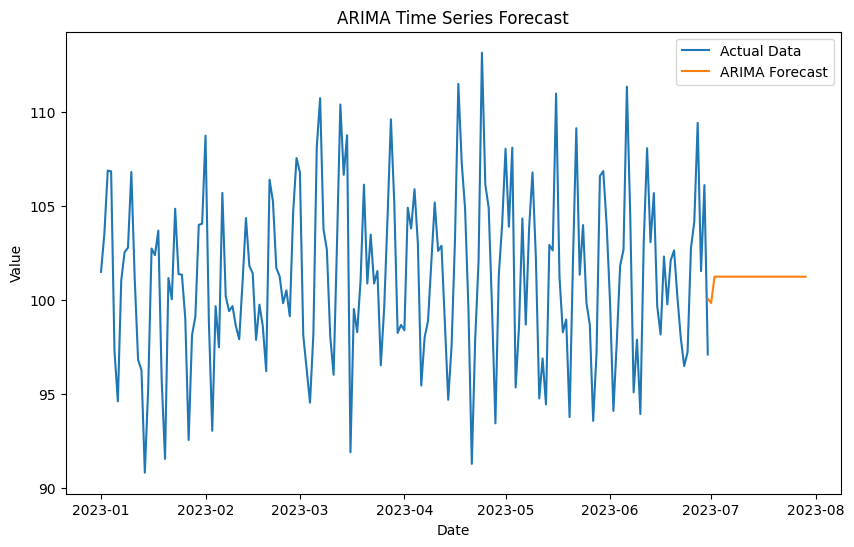

TypeError: ignored

In [ ]:
financial_data = generate_financial_data(start_date, end_date)

# ARIMA
arima_order = arima_hyperparameter_tuning(financial_data['Value'])
arima_forecast_result = arima_forecast(financial_data['Value'], order=arima_order)
evaluate_model(financial_data['Value'], arima_forecast_result, "ARIMA")
plot_arima(financial_data['Value'], arima_forecast_result)

# Holt-Winters
holt_winters_params = holt_winters_hyperparameter_tuning(financial_data['Value'])
holt_winters_forecast_result = holt_winters_forecast(financial_data['Value'], seasonal=holt_winters_params[0], seasonal_periods=holt_winters_params[1])
evaluate_model(financial_data['Value'], holt_winters_forecast_result, "Holt-Winters")
plot_holt_winters(financial_data['Value'], holt_winters_forecast_result)

# Isolation Forest
anomalies = anomaly_detection(financial_data[['Value']])
plot_anomalies(financial_data, anomalies)

# AutoARIMA
auto_arima_order = auto_arima_hyperparameter_tuning(financial_data['Value'])
auto_arima_forecast_result = auto_arima_forecast(financial_data['Value'], order=auto_arima_order)
evaluate_model(financial_data['Value'], auto_arima_forecast_result, "AutoARIMA")
plot_auto_arima(financial_data['Value'], auto_arima_forecast_result)

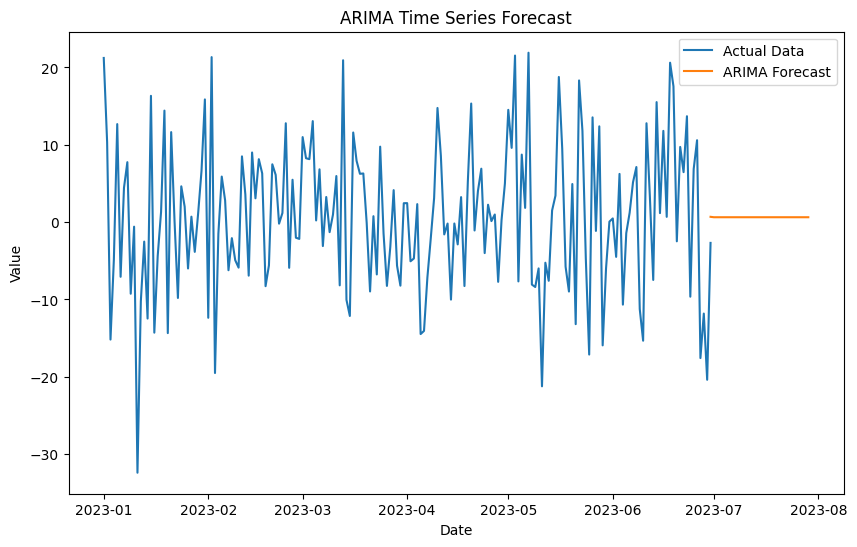

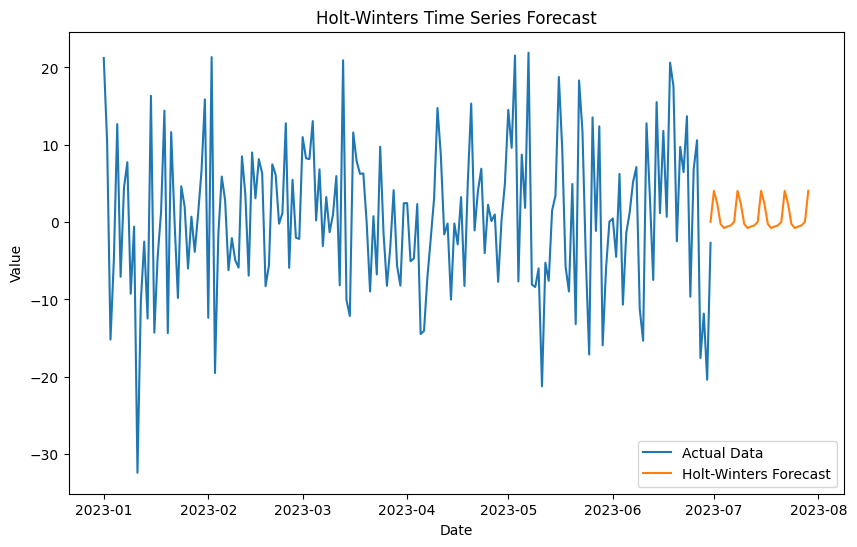

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


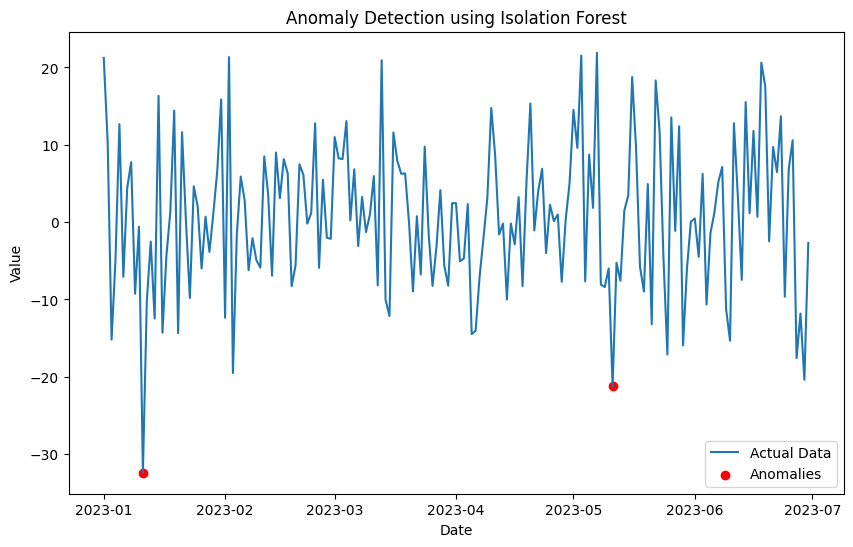

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1339.498, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1343.383, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=1343.394, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1338.253, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=1341.468, Time=0.20 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=1341.470, Time=0.15 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=1343.398, Time=0.54 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=1341.415, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=1341.424, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=1343.035, Time=0.26 sec

Best model:  ARIMA(0,0,0)(0,0,0)[7]          
Total fit time: 4.622 seconds


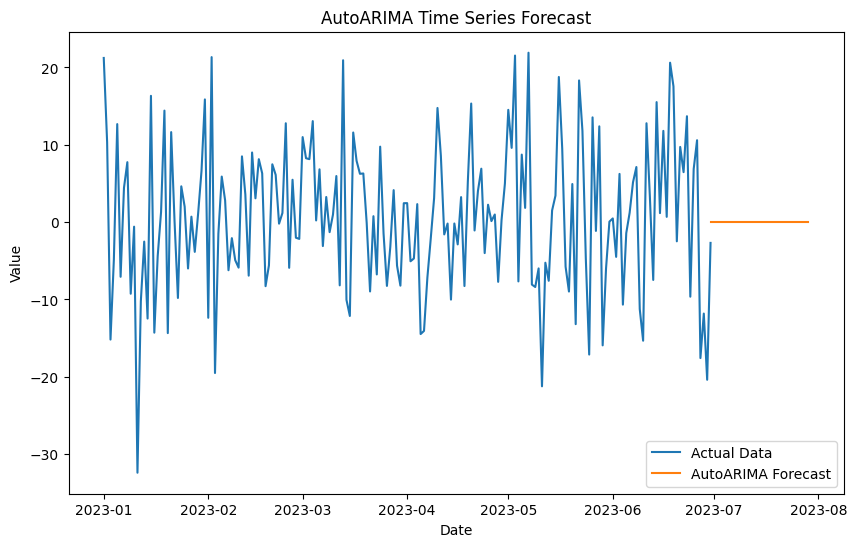

In [ ]:
# ARIMA
arima_order = (1, 1, 1)  # Replace with appropriate order for your data
arima_forecast_result = arima_forecast(financial_data['Value'], arima_order)
plot_arima(financial_data['Value'], arima_forecast_result)

# Holt-Winters
holt_winters_forecast_result = holt_winters_forecast(financial_data['Value'])
plot_holt_winters(financial_data['Value'], holt_winters_forecast_result)

# Isolation Forest
anomalies = anomaly_detection(financial_data[['Value']])
plot_anomalies(financial_data, anomalies)

# AutoARIMA
auto_arima_forecast_result = auto_arima_forecast(financial_data['Value'])
plot_auto_arima(financial_data['Value'], auto_arima_forecast_result)